In [3]:
import sys
sys.path.append('../../../util/')
import tfutil
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from os import listdir
from os.path import isfile, join

import tensorflow as tf
import tensorflow.contrib.slim as slim

import maxcell


from IPython import display

# Loading MNIST hand writing digit data.

In [4]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [5]:
X = mnist.train._images.reshape(55000,28,28)
Y = mnist.train._labels
index = np.arange(55000)
np.random.shuffle(index)

bf = tfutil.BatchFeeder(X[index[:54000]], Y[index[:54000]])
valid_data = (X[index[54000:]], Y[index[54000:]])

Answer: 1


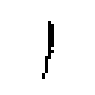

In [6]:
index = 0
Xt, Yt = bf.next(10)
print "Answer:", np.argmax(Yt[index])
plt.figure(figsize=(1.5,1.5))
plt.imshow(Xt[index].reshape(28,28))
plt.yticks([],[])
plt.xticks([],[])
plt.show()

# Building a VAE model with MLP encoder and decoder.

Defining a utility function

In [7]:
# Resets the graphs to defualt
def reset_graph():
    if 'sess' in globals() and sess:
        sess.close()
    tf.reset_default_graph()

Defining loss related functions.

In [8]:
# Calculates KL divergence between diagonal zero-mean unit-variance guass
# and latent gaussian distributions. 
def kullbackLeibler(mu, log_sigma):
    with tf.name_scope("KL_divergence"):
        return -0.5 * tf.reduce_sum(1 + 2 * log_sigma - mu**2 -
                                    tf.exp(2 * log_sigma), 1)
# KL2   
def kullbackLeibler2(mu, log_sigma):
    with tf.name_scope("KL_divergence"):
        return -0.5 * (1 + 2 * log_sigma - mu**2 -
                                    tf.exp(2 * log_sigma))
    
# Samples from latent guassian distributions using reparameterization tricks. 
def reparametrization_trick(mu, log_sigma):
    epsilon = tf.random_normal(tf.shape(log_sigma), name="epsilon")
    return mu + epsilon * tf.exp(log_sigma)

# Calculates reconstruction loss of VAE.
def crossEntropy(obs, actual, offset=1e-7):
    with tf.name_scope("cross_entropy"):
        obs_ = tf.clip_by_value(obs, offset, 1 - offset)
        return -tf.reduce_sum(actual * tf.log(obs_) +
                              (1 - actual) * tf.log(1 - obs_), 1)

In [9]:
# Renyi Divergence between Gaussians p and 0-mean unit variance gaussian. 
def renyi_gauss(alpha, mu, log_sigma, q_mu=0, q_var=1):
    p_mu = mu
    p_var = tf.exp(2*log_sigma)
    alpha_var = alpha * q_var + (1-alpha) * p_var
    renyi_divergence = 0.5 * (tf.log(q_var + 1e-8) - tf.log(p_var + 1e-8)) \
                       + 0.5 * (tf.log(q_var + 1e-8) - tf.log(alpha_var + 1e-8)) / (alpha - 1) \
                       + alpha * tf.square(p_mu - q_mu) / (2 * alpha_var + 1e-8)
    return renyi_divergence

In [10]:
def renyi_divergence(alpha, mu, log_sigma):
    return tf.cond(alpha<1.0, lambda: renyi_gauss(alpha, mu, log_sigma), lambda: kullbackLeibler2(mu, log_sigma))


Defining a simple pair of encoder and decoder

In [394]:
# 3 layers MLP
def DNN_encoder(_input, latent_size=2, fn=tf.nn.sigmoid):
    fc = slim.fully_connected(_input, 500, activation_fn=fn)
    #fc = slim.fully_connected(fc, 250, activation_fn=fn)
    fc = slim.fully_connected(fc, 100, activation_fn=fn)
    _output = slim.fully_connected(fc, latent_size, activation_fn=fn)
    return dict(
    latent = _output,
    )

In [395]:
# 3 layers MLP
def DNN_decoder(_input, output_size=784, fn=tf.nn.sigmoid, reuse=None):
    with tf.variable_scope("decoder", reuse=reuse):
        fc = slim.fully_connected(_input, 100, activation_fn=fn)
        #fc = slim.fully_connected(fc, 250, activation_fn=fn)
        fc = slim.fully_connected(fc, 500, activation_fn=fn)
        _output = slim.fully_connected(fc, output_size, activation_fn=fn)
        return dict(
        reconstruction = _output,
        )

Defining the wrapping VAE model.

In [396]:
def VAE(enc, dec):
    reset_graph()
    
    #Data loading and flattening
    data = tf.placeholder(tf.float32, (None, 28, 28))
    flattened = tf.contrib.layers.flatten(data)
    
    #Data through encoder
    encoder = enc(flattened, latent_size=10)
    
    #Variational part
    mu = slim.fully_connected(encoder['latent'], 2, activation_fn=None)
    sigma = slim.fully_connected(encoder['latent'], 2, activation_fn=None)
    
    #Sample from the specified latent distributions
    latent = reparametrization_trick(mu, sigma)
    
    #Data through decoder
    decoder = dec(latent)
    reconstruction = decoder['reconstruction']
    
    #Calclating loss
    reconstruction_loss = tf.reduce_mean(crossEntropy(reconstruction, flattened))
    KL_divergence = tf.reduce_mean(kullbackLeibler(mu, sigma))
    KL_trigger = tf.placeholder(tf.float32)
    loss = reconstruction_loss + KL_divergence*KL_trigger
    
    #Training with Adam optimizer with default learning rate. 
    train = tf.train.AdamOptimizer(0.0005).minimize(loss)
    
    return dict(
    data = data,
    train = train,
    reconstruction = reconstruction,
    loss = loss,
    latent = latent,
    mu = mu,
    sigma = sigma,
    trigger = KL_trigger,
    kl = tf.reduce_mean(kullbackLeibler2(mu, sigma), axis=0),
    rl = reconstruction_loss,
    saver = tf.train.Saver()
    )

In [397]:
def VAE_renyi(enc, dec):
    reset_graph()
    
    #Data loading and flattening
    data = tf.placeholder(tf.float32, (None, 28, 28))
    flattened = tf.contrib.layers.flatten(data)
    
    #Data through encoder
    encoder = enc(flattened, latent_size=10)
    
    #Variational part
    mu = slim.fully_connected(encoder['latent'], 2, activation_fn=None)
    sigma = slim.fully_connected(encoder['latent'], 2, activation_fn=None)
    
    #Sample from the specified latent distributions
    latent = reparametrization_trick(mu, sigma)
    
    #Data through decoder
    decoder = dec(latent)
    reconstruction = decoder['reconstruction']
    
    #Calclating loss
    #Reconstruction
    reconstruction_loss = tf.reduce_mean(crossEntropy(reconstruction, flattened))
    
    #Divergence from 0 mean unit gauss
    KL_trigger = tf.placeholder(tf.float32)
    divergence = tf.reduce_mean(renyi_divergence(KL_trigger, mu, sigma))
    loss = reconstruction_loss + divergence
    
    #Training with Adam optimizer with default learning rate. 
    train = tf.train.AdamOptimizer(0.0005).minimize(loss)
    
    return dict(
    data = data,
    train = train,
    reconstruction = reconstruction,
    loss = loss,
    latent = latent,
    mu = mu,
    sigma = sigma,
    trigger = KL_trigger,
    kl = tf.reduce_mean(renyi_divergence(KL_trigger, mu, sigma), axis=0),
    rl = reconstruction_loss,
    saver = tf.train.Saver()
    )

Training the autoencoder (AE) models

In [398]:
# Trains network g.
def train_network(g, num_epochs, feeder, batchsize, valid, verbose = True, save=False, KLD=0):
    # Calculating number of batches per epoch
    numbatch = int(np.ceil(feeder.n*1.0/batchsize))
    
    # Training happens here 
    with tf.Session() as sess:
        # initialize all variables
        sess.run(tf.global_variables_initializer())
        
        # initialize all result holders
        losses = [] #holds loss
        latents = [] #latent labels
        mus = [] #latent labels
        sigmas = [] #latent labels
        ys = [] #true labels
        valloss = [] #vaidation reconstrunction loss
        
        for e in range(num_epochs):
            epochwise = []
            epochwise_l = []
            epochwise_mu = []
            epochwise_sigma = []
            epochwise_y = [] 
            for b in range(numbatch):
                batch = feeder.next(batchsize)

                #Preparing data feeding
                if KLD != -1:
                    train_feed = {g['data']: batch[0], g['trigger']: KLD}
                    c, _, kl, rl, mu, sigma, latent = sess.run([g['loss'], g['train'], g['kl'], g['rl'], g['mu'], g['sigma'], g['latent']], feed_dict=train_feed)
                else:
                    train_feed = {g['data']: batch[0], g['trigger']: min(e*1.0/20, 1.0) }
                    c, _, kl, rl, mu, sigma, latent = sess.run([g['loss'], g['train'], g['kl'], g['rl'], g['mu'], g['sigma'], g['latent']], feed_dict=train_feed)
                
                #Recording learning trajectory 
                epochwise.append([c, kl[0], kl[1], rl])
                epochwise_l.append(latent)
                epochwise_y.append(batch[1])
                epochwise_mu.append(mu)
                epochwise_sigma.append(sigma)
                
            rl = sess.run(g['rl'], feed_dict={g['data']: valid[0]})
            valloss.append(rl)

            losses.append(epochwise)
            latents.append(epochwise_l)
            mus.append(epochwise_mu)
            sigmas.append(epochwise_sigma)
            ys.append(epochwise_y)
            ew = np.array(epochwise)
            if verbose: print "e:", np.mean(ew, axis=0), rl

        # Save if path is given.
        if isinstance(save, str):
            print "Saving to", save
            g['saver'].save(sess, save)

    return np.array(losses), np.array(latents), np.array(ys), np.array(mus), np.array(sigmas), np.array(valloss)

In [399]:
g = VAE(DNN_encoder, DNN_decoder)

In [400]:
# VAE without warmup
losses1, latents1, ys1, mus1, sigmas1, valloss1 = train_network(g, 50, bf, 64, valid_data, save="VAE_wo_warmup/model", verbose=False, KLD=1)

Saving to VAE_wo_warmup/model


In [401]:
# VAE with warmup 
losses2, latents2, ys2, mus2, sigmas2, valloss2 = train_network(g, 50, bf, 64, valid_data, save="VAE_w_warmup/model", verbose=False, KLD=-1)

Saving to VAE_w_warmup/model


In [402]:
# VAE without KLD
losses3, latents3, ys3, mus3, sigmas3, valloss3 = train_network(g, 50, bf, 64, valid_data, save="NO-KLD/model", verbose=False, KLD=0)

Saving to NO-KLD/model


In [403]:
# VAE with renyi divergence loss
vae_renyi = VAE_renyi(DNN_encoder, DNN_decoder)

In [404]:
# VAE with Renyi divergence
losses4, latents4, ys4, mus4, sigmas4, valloss4 = train_network(vae_renyi, 50, bf, 64, valid_data, save="VAE_renyi/model", verbose=False, KLD=-1)

Saving to VAE_renyi/model


In [405]:
# Saving training results
np.save("data_VAE/losses1", losses1)
np.save("data_VAE/losses2", losses2)
np.save("data_VAE/losses3", losses3)
np.save("data_VAE/losses4", losses4)

np.save("data_VAE/latents1", latents1)
np.save("data_VAE/latents2", latents2)
np.save("data_VAE/latents3", latents3)
np.save("data_VAE/latents4", latents4)

np.save("data_VAE/ys1", ys1)
np.save("data_VAE/ys2", ys2)
np.save("data_VAE/ys3", ys3)
np.save("data_VAE/ys4", ys4)

np.save("data_VAE/mus1", mus1)
np.save("data_VAE/mus2", mus2)
np.save("data_VAE/mus3", mus3)
np.save("data_VAE/mus4", mus4)

np.save("data_VAE/sigmas1", sigmas1)
np.save("data_VAE/sigmas2", sigmas2)
np.save("data_VAE/sigmas3", sigmas3)
np.save("data_VAE/sigmas4", sigmas4)

In [13]:
#Loading results
losses1 = np.load("data_VAE/losses1.npy")
losses2 = np.load("data_VAE/losses2.npy")
losses3 = np.load("data_VAE/losses3.npy")

latents1 = np.load("data_VAE/latents1.npy")
latents2 = np.load("data_VAE/latents2.npy")
latents3 = np.load("data_VAE/latents3.npy")

ys1 = np.load("data_VAE/ys1.npy")
ys2 = np.load("data_VAE/ys2.npy")
ys3 = np.load("data_VAE/ys3.npy")

mus1 = np.load("data_VAE/mus1.npy")
mus2 = np.load("data_VAE/mus2.npy")
mus3 = np.load("data_VAE/mus3.npy")

sigmas1 = np.load("data_VAE/sigmas1.npy")
sigmas2 = np.load("data_VAE/sigmas2.npy")
sigmas3 = np.load("data_VAE/sigmas3.npy")

# Learning path 

In [407]:
def plot_learning_path(losses):
    l1 = np.mean(np.array(losses), axis=1)
    plt.figure(figsize=(10,3))
    plt.subplot(1,2,1)
    plt.plot(l1[:,0])
    plt.xlim(0,50)
    plt.title("LOSS (RECONST+DIVERGENCE)")
    plt.xlabel("epochs")
    plt.subplot(1,2,2)
    plt.plot(l1[:,1], label="x")
    plt.plot(l1[:,2], label="y")
    plt.xlim(0,50)
    plt.title("divergence")
    plt.legend()
    plt.xlabel("epochs")
    plt.show()

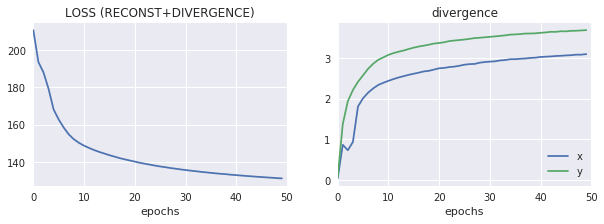

In [408]:
#1:1 KL from beginning
plot_learning_path(losses1)

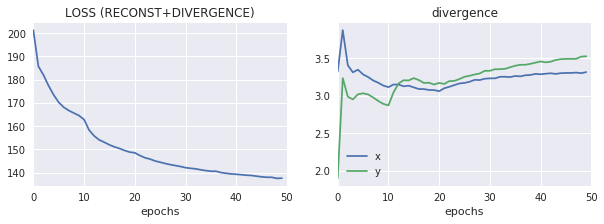

In [409]:
# Slow introduction of KL
plot_learning_path(losses2)

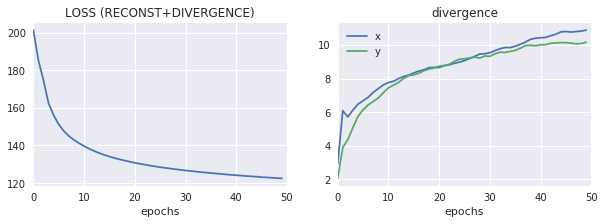

In [410]:
#No Divergence
plot_learning_path(losses3)

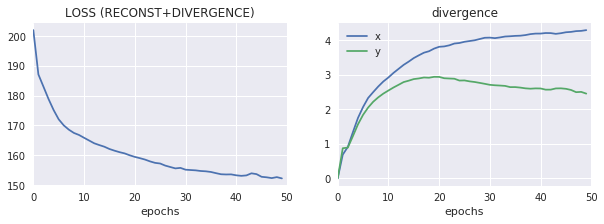

In [411]:
#Renyi
plot_learning_path(losses4)

# Digits in latent space

In [11]:
def plot_samples(mus, ys, epochs=50):
    cs = sns.color_palette("hls", 10)
    
    plt.figure(figsize=(6,6))
    for epoch in range(epochs):
        plt.clf()
        plotdict = {}
        for b in range(mus[epoch].shape[0]):
            poses = mus[epoch][b]
            targets = np.argmax(ys[epoch][b], axis=1) 
            for i in range(len(targets)):
                temp = plotdict.get(targets[i], [])
                temp.append(poses[i])
                plotdict[targets[i]] = temp

        for i in range(10):
            if i in plotdict:
                d = np.array(plotdict[i])
                plt.scatter(d[:, 0], d[:, 1], color=cs[i], label=str(i), s=0.5)
        plt.xlim(-4,4)
        plt.ylim(-4,4)
        plt.title("Epoch"+str(epoch+1))
        display.clear_output(wait=True)
        display.display(plt.gcf())
    display.clear_output(wait=True)

In [17]:
def plot_samples(mus, ys, epochs=50):
    cs = sns.color_palette("hls", 10)
    
    for epoch in range(epochs):
        plt.figure(figsize=(6,6))
        plotdict = {}
        for b in range(mus[epoch].shape[0]):
            poses = mus[epoch][b]
            targets = np.argmax(ys[epoch][b], axis=1) 
            for i in range(len(targets)):
                temp = plotdict.get(targets[i], [])
                temp.append(poses[i])
                plotdict[targets[i]] = temp

        for i in range(10):
            if i in plotdict:
                d = np.array(plotdict[i])
                plt.scatter(d[:, 0], d[:, 1], color=cs[i], label=str(i), s=0.5)
        plt.xlim(-4,4)
        plt.ylim(-4,4)
        plt.title("Epoch"+str(epoch+1))
        plt.savefig("epoch"+str(epoch+1)+".png")

In [20]:
# 1:1 KLD from the begining
x = plot_samples(mus1, ys1, 50)

In [19]:
# slow introduction of KLD
x = plot_samples(mus2, ys2, 50)

/home/nhiranuma/anaconda2/lib/python2.7/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


In [18]:
# N0 divergence measure
x = plot_samples(mus3, ys3, 50)

KeyboardInterrupt: 

In [15]:
# Renyi distribution with alpha 0->1 in 20 epochs
x = plot_samples(mus4, ys4, 50)

NameError: name 'mus4' is not defined

# Change in variance over epochs

In [ ]:
def plotvar(sigmas):
    data = []
    for e in range(sigmas.shape[0]):
        temp = []
        for b in range(sigmas.shape[1]):
            temp.append(np.mean(np.exp(sigmas[e][b]), axis=0))
        temp = np.array(temp)
        data.append(np.mean(temp, axis=0))
    print "Average variance at last epoch", data[-1]
    data = np.array(data)
    plt.figure(figsize=(6,2))
    plt.plot(data[:, 0])
    plt.plot(data[:, 1])
    plt.yscale("log")
    plt.show()

In [ ]:
plotvar(sigmas1)

In [ ]:
plotvar(sigmas2)

In [ ]:
plotvar(sigmas3)

In [ ]:
plotvar(sigmas4)

# Generating digits from latent space

In [ ]:
latent_coords = []
num = 30
_min = -3.0
_max = 3.0
for i in range(num+1):
    for j in range(num+1):
        latent_coords.append([_min+(_max-_min)*1.0/num*i, _min+(_max-_min)*1.0/num*j])
latent_coords = np.array(latent_coords)

VAE without warmup

In [ ]:
# Given a decoder graph generating function, reconstructs image from latent values.
def generate_image_from_decoder(dec, _input, save):
    # rebuilding the network
    g = VAE(DNN_encoder, DNN_decoder)
    
    # decoder only with shared weights
    latent = tf.placeholder(tf.float32, (None, 2))
    decoder = dec(latent, reuse=True)
    decoder['latent'] = latent
    
    # running the decoder
    with tf.Session() as sess:
        saver = tf.train.import_meta_graph(save+'.meta')
        saver.restore(sess,tf.train.latest_checkpoint(save.split("/")[0]+'/'))
        
        # building validation data feed dict
        val_feed = {decoder['latent']: _input}
        return sess.run(decoder['reconstruction'], feed_dict=val_feed)

In [ ]:
def plot_image_generation(key, dec, coords, num):
    sample = generate_image_from_decoder(dec, latent_coords, save=key)
    image = np.zeros((28*(num+1), 28*(num+1)))
    for i in range(num+1):
        for j in range(num+1):
            image[28*i:28*(i+1), 28*j:28*(j+1)] = (sample[i*(num+1)+j].reshape((28,28))
                                                  )
    plt.figure(figsize=(12,12))
    plt.imshow(image)
    plt.xticks([],[])
    plt.yticks([],[])
    plt.savefig(key+"generative.png")
    plt.show()

In [ ]:
plot_image_generation("VAE_wo_warmup/model", DNN_decoder, latent_coords, 30)

In [ ]:
plot_image_generation("VAE_w_warmup/model", DNN_decoder, latent_coords, 30)

In [ ]:
plot_image_generation("NO-KLD/model", DNN_decoder, latent_coords, 30)

In [ ]:
plot_image_generation("VAE_renyi/model", DNN_decoder, latent_coords, 30)

# Encoding and Decoding with LSTM

In [ ]:
def DNN_encoder(_input, latent_size=2, fn=tf.nn.sigmoid):
    fc = slim.fully_connected(_input, 500, activation_fn=fn)
    #fc = slim.fully_connected(fc, 250, activation_fn=fn)
    fc = slim.fully_connected(fc, 100, activation_fn=fn)
    _output = slim.fully_connected(fc, latent_size, activation_fn=fn)
    return dict(
    latent = _output,
    )